# <span style="color:teal"> Contradictory, My Dear Watson <a class="anchor"  id="projectTopic"></a></span>
### <span style="color:teal"> Detecting contradiction and entailment in multilingual text <a class="anchor"  id="detect"></a></span>

### <span style="color:teal">Developed by : <a class="anchor"  id="detect"></a></span>

* [Gebreyowhans Hailekiros](https://www.kaggle.com/gebreyowhansbahre/)
* [Mahbub Hasan](https://www.kaggle.com/mahbubhasanuunical)
* [Muhammad Danish Sadiq](https://www.kaggle.com/muhammaddanishsadiq/)

* This notebook is aimed at developing a neural network model which is capable of detecting contradiction and entilment in multilingual text.

### <span style="color:teal">In this following notebook: <a class="anchor"  id="detect"></a></span>
* We consider all the languages
* Our dataset is too low, so we are using [multi_nli](https://huggingface.co/datasets/multi_nli) dataset to extends our data for traning data
* And some important EDA

# Hardware Information

In [1]:
from psutil import *

# Number of available CPU
print(f"CPU Count: {cpu_count()}")

# CPU Model name
!lscpu |grep 'Model name'

# CPU Ram
ram = !free -h --si | awk '/Mem:/{print $2}'
print(f"CPU Ram: {ram}")

# Information of GPU
gpus = !nvidia-smi -L
print(f"GPU's: {gpus}")

# GPU details Information
!nvidia-smi

CPU Count: 2
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
CPU Ram: ['16G']
GPU's: ['GPU 0: Tesla T4 (UUID: GPU-e5d78800-36fd-8b89-4482-51fe910370ad)', 'GPU 1: Tesla T4 (UUID: GPU-b5bdcdf9-499c-a3f2-8969-09e005874292)']
Sat Jun 10 09:29:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|         

# Import Lib

In [2]:
!pip install -qU googletrans==3.1.0a0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [3]:
import re, string, warnings,json, random, os
warnings.filterwarnings('ignore')

from tqdm import tqdm
# for arithmetic operation
import numpy as np
# for loading csv file
import pandas as pd
# for plotting data/EDA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import tensorflow as tf

# for google translate
from googletrans import Translator

# for multi_nli dataset
from datasets import load_dataset

# Config Project

In [4]:
class ConfigProject:
    def __init__(self):
        
        self.project_input_dir = '/kaggle/input/contradictory-my-dear-watson/'
        self.train_csv = self.project_input_dir+'train.csv'
        self.test_csv = self.project_input_dir+'test.csv'
        self.submission_csv = self.project_input_dir+'sample_submission.csv'
        
        self.to_train_csv = '/kaggle/working/train.csv'
        self.to_test_csv = '/kaggle/working/test.csv'
        self.to_submission_csv = '/kaggle/working/sample_submission.csv'

conf = ConfigProject()

# Read Dataset

In [5]:
train_dataset = pd.read_csv(conf.train_csv)
test_dataset = pd.read_csv(conf.test_csv)
sample_submission = pd.read_csv(conf.submission_csv)

# General Info Of DF

In [6]:
train_dataset.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [7]:
test_dataset.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [8]:
sample_submission.head()

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,1


**Shape Of DF**

In [9]:
print(train_dataset.shape, test_dataset.shape)

(12120, 6) (5195, 5)


## Information of DF

In [10]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


In [11]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB


# EDA

### Function Plot

In [12]:
class Plotting:
    
    @classmethod
    def label_plot(self, data,plot_title='Label Count Plot'):
        fig, ax = plt.subplots(figsize=(10, 5))
        data['label'].value_counts().plot(ax=ax,kind='bar', cmap='cividis')
        plt.grid(color='gray',linestyle='--',linewidth=0.2)
        ax.set_facecolor('#d8dcd6')
        plt.title(plot_title, fontsize='18')
        plt.xticks(rotation=45)
    
    @classmethod
    def language_plot(self, data, plot_title='Label Count per Language'):
        fig, ax = plt.subplots(figsize=(10, 5))
        data.groupby(['language','label']).count()['premise'].unstack().plot(ax=ax,kind='bar', cmap='cividis')
        plt.grid(color='gray',linestyle='--',linewidth=0.2)
        ax.set_facecolor('#d8dcd6')
        plt.title(plot_title, fontsize='18')
        plt.xticks(rotation=45)

    @classmethod
    def language_pie_plot(self, data, plot_title='Language Count'):
        df = pd.DataFrame({"count": data.language.value_counts() })
        fig = px.pie(df, values='count', names=df.index, title=f'{plot_title} %',
                 labels={'index':'lang'}, color_discrete_sequence=px.colors.diverging.Earth)
        fig.update_traces(textinfo='percent')
        fig.show()
        
    @classmethod
    def word_plot(self, data, plot_title='Word Count'):
        number_of_word_premise = data['premise'].apply(lambda x: len(x.split(" ")))
        number_of_word_hypothesis = data['hypothesis'].apply(lambda x: len(x.split(" ")))
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.kdeplot(data=number_of_word_premise,
                color='crimson', label='Premise', fill=True, ax=ax)
        sns.kdeplot(data=number_of_word_hypothesis,
                color='limegreen', label='Hypothesis', fill=True, ax=ax)
        ax.legend()
        plt.tight_layout()
        plt.title(plot_title)
        plt.show()

    @classmethod
    def char_plot(self, data, plot_title='Character Count'):
        number_of_char_premise = train_dataset['premise'].apply(lambda x: len(x))
        number_of_char_hypothesis = train_dataset['hypothesis'].apply(lambda x: len(x))
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.kdeplot(data=number_of_char_premise,
                color='crimson', label='Premise', fill=True, ax=ax)
        sns.kdeplot(data=number_of_char_hypothesis,
                color='limegreen', label='Hypothesis', fill=True, ax=ax)
        ax.legend()
        plt.tight_layout()
        plt.title(plot_title)
        plt.show()

c_plot = Plotting()

### Train Dataset EDA

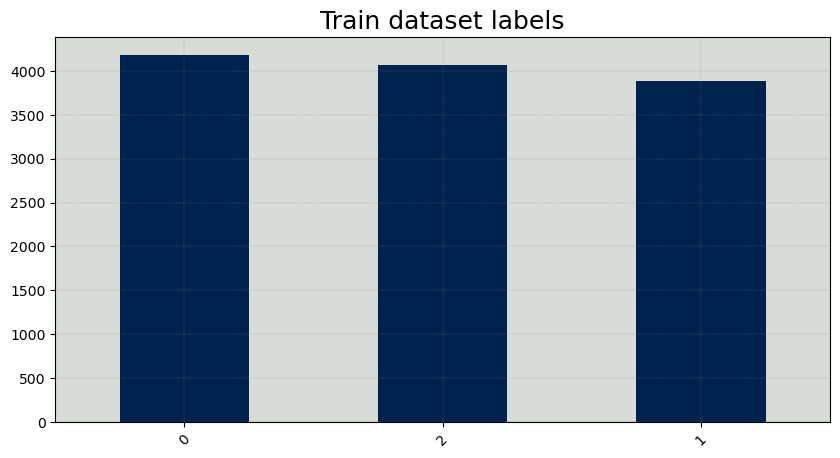

In [13]:
c_plot.label_plot(train_dataset,'Train dataset labels')

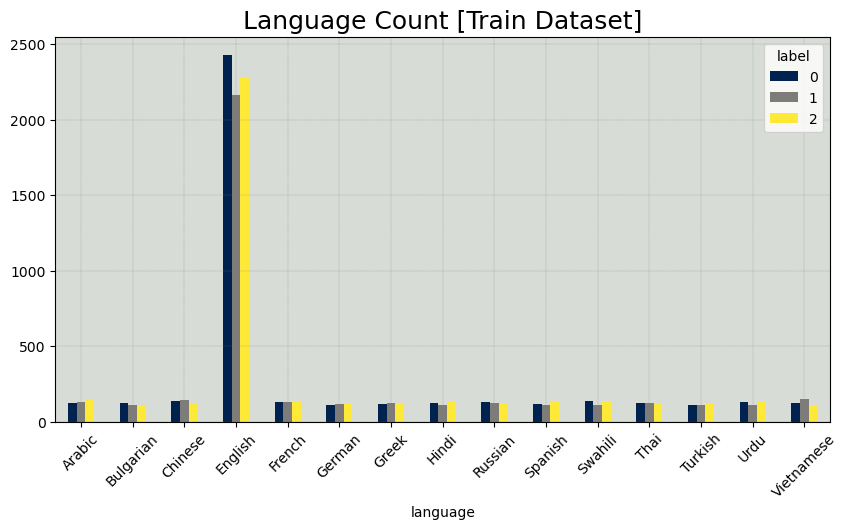

In [14]:
c_plot.language_plot(train_dataset,'Language Count [Train Dataset]')

In [15]:
# plot of languages percents
c_plot.language_pie_plot(train_dataset,'Language Count [Train Dataset]')

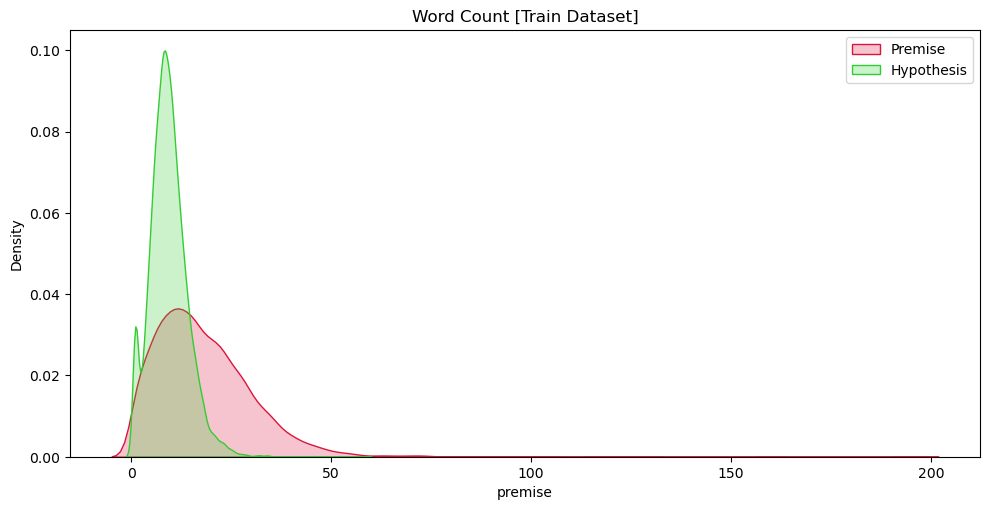

In [16]:
c_plot.word_plot(train_dataset,'Word Count [Train Dataset]')

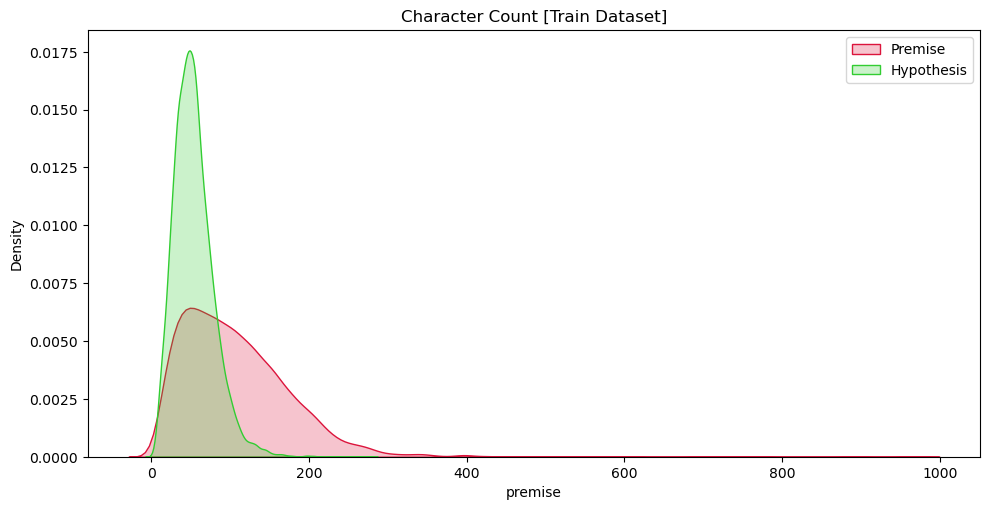

In [17]:
c_plot.char_plot(train_dataset, 'Character Count [Train Dataset]')

# Data Augmentation

**In the dataset, the label is not balanced**
* So we need to balance the dataset using google translate
* To make balance dataset,
    * Translate all [English] text to [Non-English]
    * Translate all [Non-English] text to [English]
 

In [18]:
class DataAugmentation:
    @classmethod
    def split_df_eng(self, train):
        # train dataset
        train_eng = train.loc[train.lang_abv=='en'].copy()
        train_eng.reset_index(inplace=True, drop=True)
        
        # train dataset non-english
        train_non_eng = train.loc[train.lang_abv!='en'].copy()
        train_non_eng.reset_index(inplace=True, drop=True)
        
        print(f"TRAIN DATASET ONLY ENGLISH SHAPE: {train_eng.shape}, TRAIN DATASET NON ENGLISH SHAPE: {train_non_eng.shape}")
        
        return train_eng, train_non_eng
    
    @classmethod
    def load_mnli(use_validation=True):
        result=[]
        dataset=load_dataset('multi_nli')
        print(dataset)
        for record in dataset['train']:
            c1, c2, c3 = record['premise'],record['hypothesis'], record['label']
            if c1 and c2 and c3 in {0, 1, 2}:
                result.append((c1, c2, c3, 'en'))
        result=pd.DataFrame(result, columns=['premise', 'hypothesis', 'label', 'lang_abv'])
        return result
            

    @classmethod
    def balace_label(self, train_eng, train_non_eng):
        
        def translate_language(premise, hypothesis, to_lang):
            try:
                translator = Translator()
                n_premise = translator.translate(premise, dest=to_lang).text
                n_hypothesis = translator.translate(hypothesis, dest=to_lang).text
            except:
                n_premise,n_hypothesis = premise,hypothesis
            return n_premise, n_hypothesis
        
        list_of_non_eng_lang = np.array(train_non_eng.lang_abv.unique())
        list_of_non_eng_lang
        
        # convert eng to non-eng language
        for row_index in tqdm(range(len(train_eng))):
            to_lang = random.choice(list_of_non_eng_lang)
            try:
                train_eng.loc[row_index]['premise'], train_eng.loc[row_index]['hypothesis'] = translate_language(
                    train_eng.loc[row_index]['premise'], 
                    train_eng.loc[row_index]['hypothesis'],
                    to_lang)
            except:
                list_of_non_eng_lang.remove(to_lang)
        
        # Convert non-eng to eng
        for row_index in tqdm(range(len(train_non_eng))):
            train_non_eng.loc[row_index]["premise"], train_non_eng.loc[row_index]["hypothesis"] = translate_language(
                train_non_eng.loc[row_index]['premise'],
                train_non_eng.loc[row_index]['hypothesis'],
                'en')
        
        return train_eng, train_non_eng
        
augment = DataAugmentation()

In [19]:
# Split data into eng and non-eng
train_eng, train_non_eng = augment.split_df_eng(train_dataset)

# convert [eng->non-eng] AND [non-eng -> eng]
train_eng, train_non_eng = augment.balace_label(train_eng, train_non_eng)

# merge dataset [train_dataset, train_eng (converted), train_non_eng (converted)]
data_frames = [train_dataset, train_eng, train_non_eng]
train_df = pd.concat(data_frames)
train_df.reset_index(inplace=True,drop=True)

TRAIN DATASET ONLY ENGLISH SHAPE: (6870, 6), TRAIN DATASET NON ENGLISH SHAPE: (5250, 6)


100%|██████████| 5250/5250 [18:43<00:00,  4.67it/s]


In [20]:
train_df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
24235,eae412f48e,"Да, - сказал Огле, - это правда. Но были и те,...",Огл никогда не упоминал противников существующ...,ru,Russian,2
24236,31f0c3d2d3,Οι λειτουργίες C-R μπορούν επίσης να εκτιμηθού...,Οι λειτουργίες C-R μπορούν να εκτιμηθούν με δι...,el,Greek,1
24237,39ea2c1e23,"-concevoir, dessiner et coudre à la main tous ...",Les costumes n'étaient travaillés que par des ...,fr,French,1
24238,30a3361a15,ہم نہیں جانتے تھے کہ یو 2 (U2) کیا تھا اور کوئ...,ہم نے ہوا میں جو چیز دیکھی ہمیں اس کا نام معلو...,ur,Urdu,1


**After balancing the label data, out total number of row is very low which is not efficient for NN process**
   * To increase the data volume we use **multi_nli** data
   * As we choose only english language in this model so multi_nli is very effective for us. Because multi_nli corpas was builded only english lanuage
   * First, we download the dataset (using load_dataset lib) and make a format according to our dataset
   * After that, we marge (our balanced dataset with multi_nli first 100000 data)
   * Finally, our dataset size is **(24240 + 50000)**, which is good for NN process in the next phase

In [21]:
# Download mnli dataset
mnli_dataset = augment.load_mnli()
mnli_dataset

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})


,premise,hypothesis,label,lang_abv
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en
3,How do you know? All this is their information...,This information belongs to them.,0,en
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en
...,...,...,...,...
392697,"Clearly, California can - and must - do better.",California cannot do any better.,2,en
392698,It was once regarded as the most beautiful str...,So many of the original buildings had been rep...,1,en
392699,Houseboats are a beautifully preserved traditi...,The tradition of houseboats originated while t...,0,en
392700,Obituaries fondly recalled his on-air debates ...,The obituaries were beautiful and written in k...,1,en


In [22]:
# marge train_bal_df and mnli_dataset
train_df = pd.concat([train_df, mnli_dataset.loc[:50000]],axis=0)
train_df.reset_index(inplace=True, drop=True)

In [23]:
train_df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
74236,NaN,"In Trinidad, Motel Las Cuevas has a disco with...",There is a disco in Motel Las Cuevas.,en,NaN,0
74237,NaN,Tommy's heart sank at the sight of them.,The sight of them cheered Tommy up.,en,NaN,2
74238,NaN,"Wodehouse, Paul Gigot and Mary McGrory.",Paul Gigot and others.,en,NaN,1
74239,NaN,Democrats think they're immune to this attack ...,Democrats think they have covered both ends of...,en,NaN,0


In [24]:
print(f'- Trian size: {train_df.shape} and Test size: {test_dataset.shape}')

- Trian size: (74241, 6) and Test size: (5195, 5)


# Save into output

In [25]:
train_df.to_csv(conf.to_train_csv)
test_dataset.to_csv(conf.to_test_csv)
sample_submission.to_csv(conf.to_submission_csv)